In [49]:
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation, strip_numeric,strip_short
nltk.download('wordnet')
np.random.seed(2018)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [76]:
folder = "E:/taniesta/Columbia University/Courses Files/Semester II/Applied ML in Fin/project data/"
dt = pd.read_csv(folder+"filtered_reviews_rs.csv")

AttributeError: module 'pandas' has no attribute 'read_txt'

In [5]:
print(dt.shape)
print(dt["business_id"].describe())
dt.head()

(292144, 9)
count                     292144
unique                      2013
top       K7lWdNUhCbcnEvI0NhGewg
freq                        6887
Name: business_id, dtype: object


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,f0B9-r14-bLudyu5S7aLhw,SvMGr_Oih7ivtzmnCL-Tmg,ujHiaprwCQ5ewziu0Vi9rw,1.0,1,0,0,We had dinner at the Bellagio Buffet last nigh...,2013-12-07 00:14:06
1,E4LqIZ7DJd_R4ZHSNKx4RQ,DoRCeCcJbrsM2BiAKj3trA,SU56w479vUfFHsvmvQIf7A,4.0,7,5,6,So good! They didn't make it to 5 stars due to...,2016-07-25 03:55:20
2,QSe9EqmiImbguDVIraX_rg,II8eB5mYk200GW-m-wpsug,z9aXGRH8xtqpNDFE5_I3KA,4.0,0,0,0,received a mailer and thought okay let's go. ...,2015-06-21 00:56:28
3,EedJ77WTwkytYhAR-PVMKQ,piYjHlLZQCtg9Q1QT0Lvbw,gOOfBSBZlffCkQ7dr7cpdw,5.0,0,0,0,Five stars! I highly recommend this place if y...,2018-04-27 18:59:14
4,w1I8U4cJ4QGaXA98ImNrbA,rJNdeta-dYO2YcJ3u5JxnA,faPVqws-x-5k2CQKDNtHxw,5.0,0,0,0,"Service was amazing, Christina was extremely t...",2018-08-04 20:22:15


In [6]:
count_table = dt["business_id"].value_counts()
len_text = [len(text.split()) for text in dt["text"]]
pd.DataFrame(len_text).describe()

,0
count,292144.000000
mean,107.001318
std,101.992747
min,1.000000
25%,41.000000
50%,74.000000
75%,137.000000
max,1010.000000


In [8]:
count_table['K7lWdNUhCbcnEvI0NhGewg']

6887

In [44]:
###get samples from reviews
frames = []
size = 50
for id in dt['business_id'].unique():
    ntext = count_table[id]
    if ntext<=size:
        frames.append(dt[dt['business_id']==id].iloc[:,[2,7]])
    else:
        index = np.random.choice(ntext-1,size = size,replace = False)
        frames.append(dt[dt['business_id']==id].iloc[index,[2,7]])
dt_s = pd.concat(frames)
dt_s.shape

(64229, 2)

In [45]:
#### This chunk reeeeally takes time!!!! #####
#language detecting
from langdetect import detect
language_list = []
c = 0
for text in dt_s["text"]:
    try:
        language_list.append(detect(text))
    except:
        language_list.append("unknown")
        print(c)
    c+=1
len(dt_s['text']) - language_list.count('en')

5084
5604
5649
5795
5841
5859
5872
5886
8577
8589
8604
8628
8735
8820
9277
9372
9445
16923
26210
41085
44898
46587
48723
63155


202

In [78]:
dt_s.to_csv(folder + "sampled_reviews.csv")
dt_s.to_csv(folder + "sampled_reviews.txt",sep = "\t")

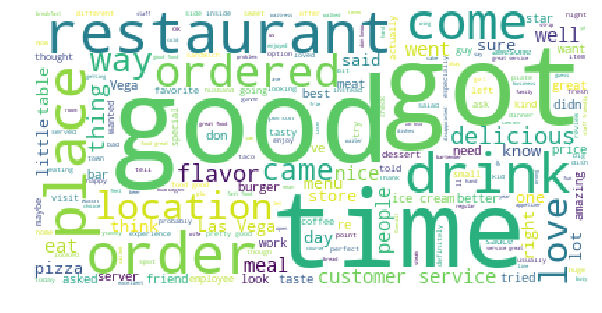

In [61]:
#define a function get_wordcloud to generate wordcloud given a dataset
def get_wordcloud(data):
    Words = [strip_punctuation(strip_numeric(strip_short(remove_stopwords(word)))) for word in data]
    if "got" in Words:
        Words.remove("got")
    Text = ''.join(Words)
    Text.lower()
    plot = plt.imshow(WordCloud(background_color = "white").generate(Text))
    plt.axis('off')
    plt.rcParams['figure.figsize'] = (10,10)
    plt.show()
    return plot
plot = get_wordcloud(dt_s['text'])

In [63]:
stemmer = nltk.SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = list(map(preprocess,dt_s['text']))

In [65]:
#prepare corpus
corpus=[preprocess(tag) for tag in dt_s['text']]
dictionary = gensim.corpora.Dictionary(corpus)

dictionary.filter_extremes(no_below=2, no_above=0.99)
corpus = [dictionary.doc2bow(preprocess(tag)) for tag in dt_s['text']]

In [67]:
#lda model
lda_model = gensim.models.LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         random_state=100, 
                         num_topics=10,
                         passes=5,
                         chunksize=10000,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
lda_model.print_topics(-1)

[(0,
  '0.026*"food" + 0.025*"place" + 0.021*"great" + 0.020*"good" + 0.014*"servic" + 0.013*"love" + 0.011*"like" + 0.011*"friend" + 0.010*"come" + 0.010*"time"'),
 (1,
  '0.018*"good" + 0.016*"order" + 0.014*"chicken" + 0.014*"food" + 0.011*"like" + 0.011*"fri" + 0.011*"come" + 0.009*"place" + 0.009*"sauc" + 0.008*"salad"'),
 (2,
  '0.039*"doughnut" + 0.015*"macaron" + 0.014*"creme" + 0.011*"float" + 0.007*"brian" + 0.007*"brûlée" + 0.006*"bobbi" + 0.006*"pink" + 0.006*"teavana" + 0.006*"snooti"'),
 (3,
  '0.099*"pizza" + 0.044*"order" + 0.017*"deliveri" + 0.015*"wing" + 0.015*"place" + 0.014*"time" + 0.012*"good" + 0.011*"chees" + 0.010*"crust" + 0.009*"like"'),
 (4,
  '0.032*"taco" + 0.028*"food" + 0.015*"good" + 0.014*"burrito" + 0.013*"like" + 0.012*"locat" + 0.011*"place" + 0.011*"mexican" + 0.010*"meat" + 0.010*"fresh"'),
 (5,
  '0.071*"water" + 0.021*"great" + 0.016*"latt" + 0.015*"coffe" + 0.015*"drink" + 0.012*"gallon" + 0.011*"peruvian" + 0.010*"servic" + 0.010*"chai" + 0.0

In [83]:
dt_txtarr = pd.DataFrame({"business_id": dt_s["business_id"],"text":[' '.join(arr) for arr in processed_docs]})

In [86]:
dt_txtarr.to_csv(folder + "preprocessed_reviews.csv")

In [125]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(dt_txtarr["text"])
print(vectorizer.get_feature_names())

['aaron', 'abandon', 'abil', 'abl', 'absent', 'absolut', 'absorb', 'absurd', 'abund', 'abus', 'acai', 'accent', 'accept', 'access', 'accessori', 'accid', 'accident', 'accommod', 'accomod', 'accompani', 'accomplish', 'accord', 'account', 'accur', 'accus', 'accustom', 'ach', 'achiev', 'acid', 'acknowledg', 'acquir', 'act', 'action', 'activ', 'actual', 'adam', 'add', 'addict', 'addit', 'address', 'adequ', 'adjac', 'adjust', 'admir', 'admiss', 'admit', 'adobada', 'adobo', 'ador', 'adorn', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'aesthet', 'affair', 'affect', 'afford', 'aforement', 'afraid', 'african', 'afternoon', 'aftertast', 'afterward', 'agav', 'age', 'agent', 'aggrav', 'aggress', 'agre', 'agua', 'ahead', 'ahhh', 'ahogada', 'aioli', 'airi', 'airlin', 'airport', 'aisl', 'ala', 'alarm', 'albacor', 'albeit', 'albertson', 'alcohol', 'alert', 'alex', 'alfredo', 'aliant', 'alien', 'alik', 'aliv', 'alkalin', 'allerg', 'allergi', 'alley', 'allow', 'almond', 'alo

In [126]:
from sklearn.decomposition import PCA
pca = PCA()
pc = pca.fit_transform(X.toarray())

In [148]:
pc_dt = pd.DataFrame(pc).iloc[:,0:30]
dt_ss = dt_s.reset_index(drop = True)
pc_dt = pd.concat([pc_dt,dt_ss["business_id"]],axis =1)
pc_dt.to_csv(folder+"reviews_tfidf_pcs.csv")

In [151]:
pc_dt.groupby('business_id').mean()
pc_dt.groupby('business_id').mean().to_csv(folder+"agg_pc.csv")